In [ ]:
!pip install pandas
!pip install os
!pip install numpy 
!pip install opencv-python
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install xgboost

# Necessary Imports

In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Get the path of the folders that contains the photos using *get_internal_paths*  

In [2]:
def get_internal_paths(path):

    # Get the list of all items (files and folders) within the parent folder
    items = os.listdir(path)

    # Initialize an empty list to store the paths of the four folders
    folder_paths = []

    # Iterate through all items in the parent folder
    for item in items:
        item_path = os.path.join(path, item)
        
        # Check if the item is a folder (directory)
        if os.path.isdir(item_path):
            folder_paths.append(item_path)

    # Print the paths of the four folders

    return folder_paths


# Get the path of the photos inside each folder a longside with its label 

In [3]:

def get_images(path):
    internal_paths = get_internal_paths(path)
    # Directory containing image files
    classes = []
    image_files = []
    for path in internal_paths:
        directory_path = path
        dirc = os.listdir(directory_path)
        # List all image files in the directory
        image_files += [os.path.join(path, file) for file in dirc if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
        classes += [path.split("\\")[1]] * (len(dirc) - 2)
    return image_files, classes


# Putting the paths and the labels in a dataframe & shuffle the data  
shuffling data here is necessary as image_paths is a list that contains the paths of all images starting at the first folder ending with the last folder.  
so the data is not random and that would produce a bad ML model.  
Its important to put the paths & the labels in a dataframe or any to 2d array to insure that the data is shuffled in **the same order**.

In [4]:
image_paths, class_labels = get_images("./animals")  # List of paths to your image files
distinct_labels = set(class_labels)
data = {'Image path': image_paths[:-1], 'Class': class_labels}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=5).reset_index(drop=True)
df

Image path    Class
0    ./animals\leopard\667666c2-de94-41d7-ad56-6639...  leopard
1    ./animals\leopard\469471d1-f402-4041-8910-b150...  leopard
2    ./animals\leopard\cf75f0ec-f9f5-4ce5-9a4b-a3af...  leopard
3    ./animals\cheetah\e6531503-cc5e-4178-8608-1846...  cheetah
4    ./animals\lion\a1666eba-596c-40b1-a325-2bc4a45...     lion
..                                                 ...      ...
725  ./animals\cheetah\668ca3cb-8a60-4702-b5a3-0a65...  cheetah
726  ./animals\lion\3d2ea8c2-4d23-4085-9367-9b15358...     lion
727  ./animals\cheetah\a799638a-212d-4f98-8f35-84ec...  cheetah
728  ./animals\tiger\d68b45fc-17fb-4386-bf0c-53c6e6...    tiger
729  ./animals\leopard\1d656279-fbbc-4044-a7f2-054c...  leopard

[730 rows x 2 columns]

# One-hot encoding for the labels of the photos  
**cheetah: 0**   
**leopard: 1**   
**lion:    2**      
**tiger:   3**  

In [5]:
labels = LabelEncoder()
df['Class labels'] = labels.fit_transform(df['Class'])
df

Image path    Class  Class labels
0    ./animals\leopard\667666c2-de94-41d7-ad56-6639...  leopard             1
1    ./animals\leopard\469471d1-f402-4041-8910-b150...  leopard             1
2    ./animals\leopard\cf75f0ec-f9f5-4ce5-9a4b-a3af...  leopard             1
3    ./animals\cheetah\e6531503-cc5e-4178-8608-1846...  cheetah             0
4    ./animals\lion\a1666eba-596c-40b1-a325-2bc4a45...     lion             2
..                                                 ...      ...           ...
725  ./animals\cheetah\668ca3cb-8a60-4702-b5a3-0a65...  cheetah             0
726  ./animals\lion\3d2ea8c2-4d23-4085-9367-9b15358...     lion             2
727  ./animals\cheetah\a799638a-212d-4f98-8f35-84ec...  cheetah             0
728  ./animals\tiger\d68b45fc-17fb-4386-bf0c-53c6e6...    tiger             3
729  ./animals\leopard\1d656279-fbbc-4044-a7f2-054c...  leopard             1

[730 rows x 3 columns]

# Extracting features
the next block of code extracts the feature from the photos using VGG16 which we will use to train a model and make predictions.   
this article is helpful [Extracting data using VGG](https://medium.com/coinmonks/vgg16-and-vgg19-cnn-models-how-to-extract-features-display-filters-and-create-feature-maps-c456cc2ef6b1#:~:text=VGG16%20and%20VGG19%20CNN%20Models%3A%20How%20to%20Extract,Each%20Conv%20Layer%E2%80%99s%20Feature%20Map%20...%20More%20items).  
VGG models are deep learning models that are used to extract features from photos.

In [6]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
features = []

for path in df['Image path']:
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    features.append(vgg16_model.predict(img))
    

1/1 [==============================] - 0s 113ms/step


In [7]:
np_features = np.array(features) #converting the features from a list to a numpy array

# Splitting the data  
the next cell splits the data into training, validation, and test with 70 - 10 - 20 % respectively

In [8]:
# Reshape 'features' to 2D array it has the shape(730, 1, 7, 7, 512)
num_samples, feature_dim = np_features.shape[0], np.prod(np_features.shape[1:])
np_features = np_features.reshape(num_samples, feature_dim) # the shape now is (730, 7*7*512 = 25088)

# Split the data into training and test sets
X_train, X_temp, y_train, y_temp = train_test_split(np_features, np.array(df['Class labels']), test_size=0.3, random_state=5)

# Split the remaining data into validation (10%) and testing (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=5)

# Training a model

## Training a support vector machine

Validation Accuracy: 0.9444444444444444
Testing Accuracy: 0.9251700680272109


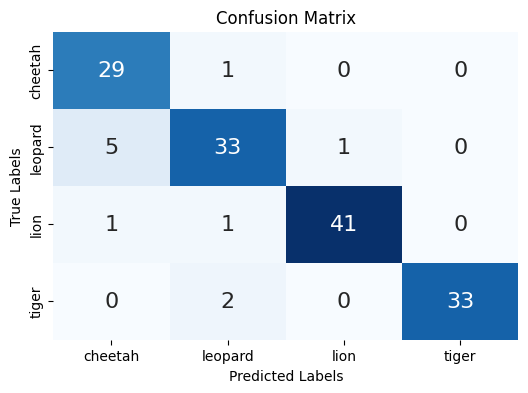

F1 Score: 0.925786346927435


In [9]:
# Train a support vector machine (SVM) with a linear kernel
model = SVC(kernel='linear')

# Train the model using the training set
model.fit(X_train, y_train)

# Validate the model using the validation set
y_val_pred = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the model on the testing set
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy_test)

# Calculate the confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for the x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score to evaluate model performance
f1_svc = f1_score(y_test, y_test_pred, average='weighted')

print("F1 Score:", f1_svc)

we see that the validation accuracy is high & the difference between test and val accuracy is small which means that the model generalizes will.  
and the F1-score is pretty good.  
The F1 score is a metric that balances precision and recall and is useful for imbalanced datasets.  
and here we have a confusion matrix which tells us how many examples the model misclassified to another class.      
<hr>

## Training a logistic regression model

Validation Accuracy: 0.9027777777777778
Testing Accuracy: 0.9319727891156463


c:\Users\mohamed ibrahim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


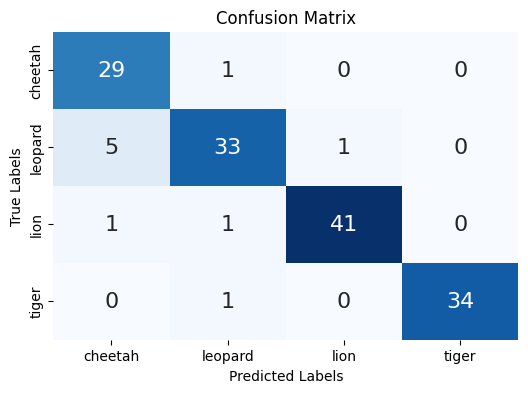

F1 Score: 0.932410458051671


In [10]:
# Create a Logistic Regression model
model = LogisticRegression()

# Train the model using the training set
model.fit(X_train, y_train)

# Validate the model using the validation set
y_val_pred = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the model on the testing set
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy_test)

# Calculate the confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score to evaluate model performance
f1_lr = f1_score(y_test, y_test_pred, average='weighted')

print("F1 Score:", f1_lr)


here the validation accuracy is less than of the svm but the test accuracy is higher  
<hr>

## Training an XGboost model

Validation Accuracy: 0.8472222222222222
Test Accuracy: 0.9319727891156463


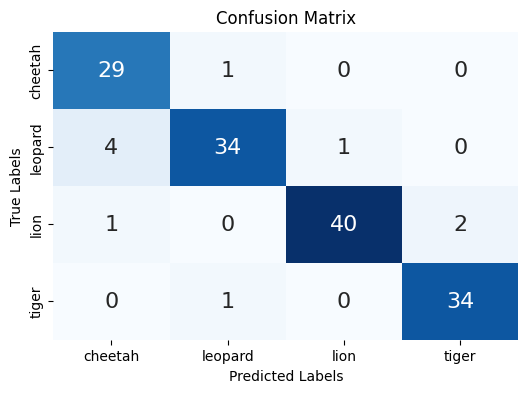

Misclassified Indices: [ 13  24  41  44  46  85 103 115 133 135]
F1 Score: 0.9321156987275125


In [11]:
# Define the XGBoost model and its hyperparameters
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,        # Learning rate of the XGBoost model (step size during training)
    n_estimators=100,         # Number of boosting rounds (number of trees in the ensemble)
    max_depth=3,              # Maximum depth of each tree in the ensemble
    subsample=0.8,            # Subsample ratio of the training instances (for each tree)
    colsample_bytree=0.8,     # Subsample ratio of the features (for each tree)
    random_state=5            # Seed for random number generator for reproducibility
)

# Train the XGBoost model using the training set
xgb_model.fit(X_train, y_train)

# Validate the XGBoost model using the validation set
y_val_pred = xgb_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the XGBoost model on the testing set
y_test_pred = xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)

# Calculate the F1 score to evaluate XGBoost model performance
f1_xgb = f1_score(y_test, y_test_pred, average='weighted')

# Calculate the confusion matrix to evaluate XGBoost model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Find the indices of misclassified instances
misclassified_indices_xgb = np.where(y_test_pred != y_test)[0]

# Print the indices of misclassified instances
print("Misclassified Indices:", misclassified_indices_xgb)

# Calculate the F1 score to evaluate model performance (already calculated above, but included for clarity)
f1_xgb = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score
print("F1 Score:", f1_xgb)


here we see that the validation accuracy is much lower than the LR & SVM models but the test acc. is nearly the same
<hr>

## Training a random forest classifier

In [12]:
# Create a Random Forest model with specific hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees in the forest
    max_depth=10,                 # Maximum depth of each tree in the forest
    min_samples_split=2,          # Minimum number of samples required to split an internal node
    min_samples_leaf=1,           # Minimum number of samples required to be at a leaf node
    random_state=5                # Seed for random number generator for reproducibility
)

# Train the Random Forest model using the training set
rf_model.fit(X_train, y_train)

# Validate the Random Forest model using the validation set
y_val_pred = rf_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the Random Forest model on the testing set
y_test_pred = rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)


Validation Accuracy: 0.9166666666666666
Test Accuracy: 0.9183673469387755


the accuracy of this model is pretty good also.
<hr>

## Training a k-nearest neighbors classifier

In [13]:
# Create a K-Nearest Neighbors (KNN) model
model = KNeighborsClassifier()

# Train the KNN model using the training set
model.fit(X_train, y_train)

# Validate the KNN model using the validation set
y_val_pred = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the KNN model on the testing set
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy_test)

# Calculate the F1 score to evaluate KNN model performance
f1_Kn = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score
print("F1 Score:", f1_Kn)


Validation Accuracy: 0.75
Testing Accuracy: 0.8299319727891157
F1 Score: 0.8290536564044536


here we see that the k-nearest neighbors is a bad model to our data set.
<hr>

# Fine-Tunning selected models
which are svm, LR & Xgb

##  Fine-Tunning the SVM model

In [14]:
# Create a Support Vector Machine (SVM) model
svm_model = SVC()

# Define the hyperparameter grid for Grid Search
param_grid = {
    'C': [1, 10, 100],         # Values of regularization parameter C to try
    'kernel': ['linear', 'rbf', 'poly'],  # Kernels to try: linear, radial basis function (rbf), and polynomial (poly)
}

# Create a Grid Search object with the SVM model and the hyperparameter grid
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform Grid Search to find the best hyperparameters on the training set
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model found by Grid Search
best_params_svg = grid_search.best_params_
best_model_svg = grid_search.best_estimator_

# Train the best model using the entire training set
best_model_svg.fit(X_train, y_train)

# Validate the best model using the validation set
y_val_pred = best_model_svg.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the best model on the testing set
y_test_pred = best_model_svg.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)

# Find the indices of misclassified instances by comparing predicted labels and true labels
hyper_misclassified_indices_svm = np.where(y_test_pred != y_test)[0]

# Print the indices of misclassified instances
print("Misclassified Indices:", hyper_misclassified_indices_svm)

# Calculate the F1 score to evaluate the best model's performance
f1_svc = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score
print("F1 Score:", f1_svc)


Validation Accuracy: 0.9444444444444444
Test Accuracy: 0.9591836734693877
Misclassified Indices: [ 13  41  99 103 133 135]
F1 Score: 0.9590832301101764


we see that the accuracy of the best model is here than the first SVM model.  
the next code gives us the parameters to be passed to the SVC function to get the best SVM model.

### best SVM Model

best hyperparameters: {'C': 100, 'kernel': 'rbf'}
best model: SVC(C=100)


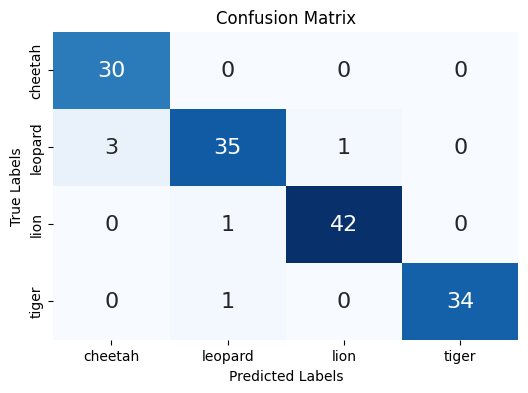

In [15]:
# Print the best hyperparameters found by Grid Search for the SVM model
print(f"best hyperparameters: {best_params_svg}")

# Print the best SVM model found by Grid Search
print(f"best model: {best_model_svg}")

# Calculate the confusion matrix to evaluate SVM model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


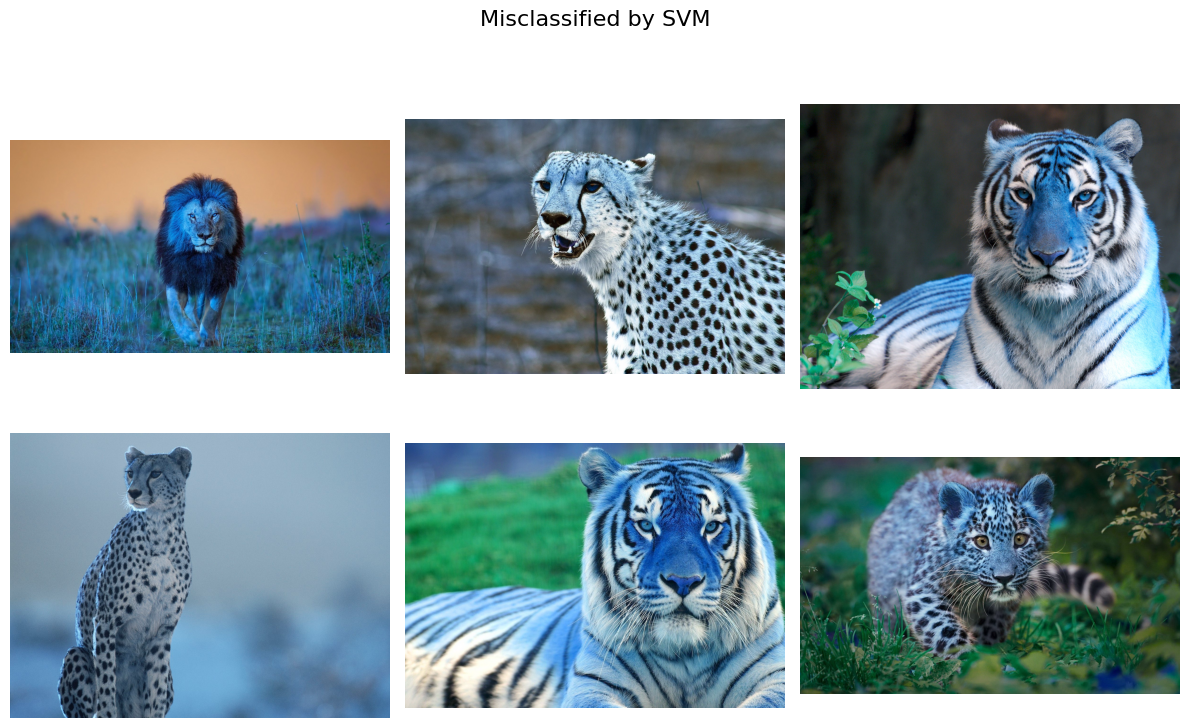

In [16]:
# Create a figure with a size of 12x8 inches to display the misclassified images
plt.figure(figsize=(12, 8))

# Iterate through the misclassified indices of the SVM model's predictions
for i in range(len(hyper_misclassified_indices_svm)):
    # Get the image path from the DataFrame using the misclassified index
    image_path = df.iloc[hyper_misclassified_indices_svm[i], 0]

    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Create a subplot grid with 2 rows and 3 columns and set the current subplot position
    plt.subplot(2, 3, i + 1)

    # Display the image on the current subplot
    plt.imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    plt.axis('off')

# Add a super title to the entire figure
plt.suptitle('Misclassified by SVM', fontsize=16)

# Adjust the spacing between the subplots to avoid overlap
plt.tight_layout()

# Show the figure with the misclassified images
plt.show()


here we see the photos that this model has misclassified

## Fine-Tunning the Logisitic regression model

In [17]:
# Create a Logistic Regression model
logistic_model = LogisticRegression()

# Define a dictionary 'param_grid' containing hyperparameter options for Grid Search
param_grid = {
    'C': [0.1, 1, 10],            # Regularization strength (smaller values specify stronger regularization)
    'penalty': ['l1', 'l2'],      # Regularization type ('l1' for Lasso, 'l2' for Ridge)
    'solver': ['liblinear'],      # Optimization algorithm for the model ('liblinear' is suitable for small datasets)
    'max_iter': [100, 200, 500],  # Maximum number of iterations for the solver to converge
}

# Create a GridSearchCV object 'grid_search' with Logistic Regression model and param_grid
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters found by Grid Search
best_params_lr = grid_search.best_params_

# Get the best Logistic Regression model based on the best hyperparameters
best_model_lr = grid_search.best_estimator_

# Use the best model to predict the labels for the validation set
y_val_pred = best_model_lr.predict(X_val)

# Calculate the accuracy of the best model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Use the best model to predict the labels for the testing set
y_test_pred = best_model_lr.predict(X_test)

# Calculate the accuracy of the best model on the testing set
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)

# Find the indices of misclassified instances in the testing set
hyper_misclassified_indices_lr = np.where(y_test_pred != y_test)[0]

# Print the indices of misclassified instances
print("Misclassified Indices:", hyper_misclassified_indices_lr)

# Calculate the weighted F1 score for the best model on the testing set
f1_lr = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score
print("F1 Score:", f1_lr)



Validation Accuracy: 0.9305555555555556
Test Accuracy: 0.9455782312925171
Misclassified Indices: [ 13  19  24  41  99 103 133 135]
F1 Score: 0.9456227080567434


### best logisitic regression model

best hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
best model: LogisticRegression(C=0.1, solver='liblinear')


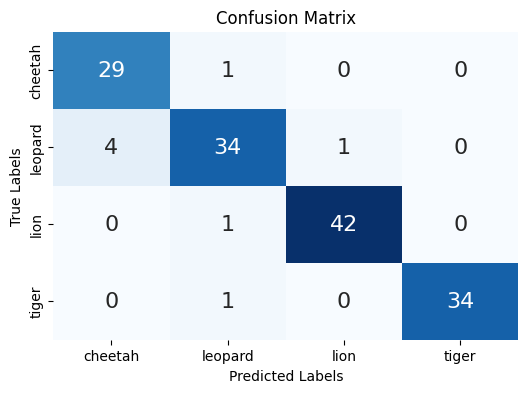

In [18]:
# Print the best hyperparameters found by Grid Search for the SVM model
print(f"best hyperparameters: {best_params_lr}")

# Print the best SVM model found by Grid Search
print(f"best model: {best_model_lr}")

# Calculate the confusion matrix to evaluate SVM model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

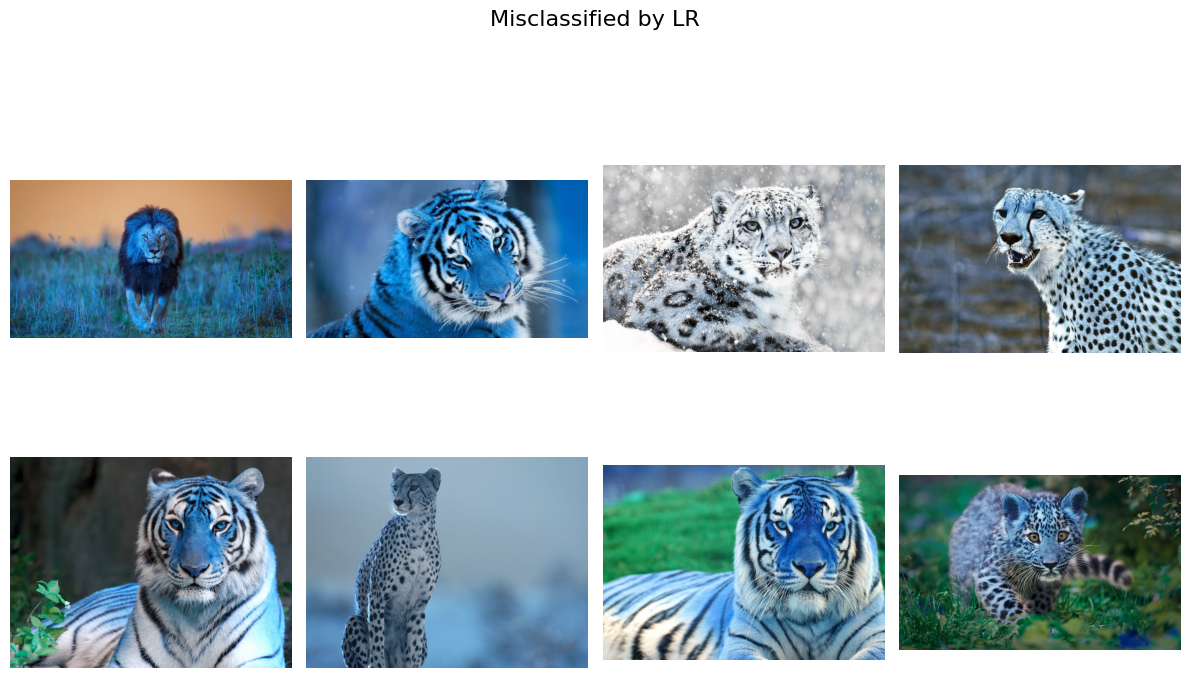

In [19]:
# Create a figure with a size of 12x8 inches to display the misclassified images
plt.figure(figsize=(12, 8))

# Iterate through the misclassified indices of the LR model's predictions
for i in range(len(hyper_misclassified_indices_lr)):
    # Get the image path from the DataFrame using the misclassified index
    image_path = df.iloc[hyper_misclassified_indices_lr[i], 0]

    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Create a subplot grid with 2 rows and 3 columns and set the current subplot position
    plt.subplot(2, 4, i + 1)

    # Display the image on the current subplot
    plt.imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    plt.axis('off')

# Add a super title to the entire figure
plt.suptitle('Misclassified by LR', fontsize=16)

# Adjust the spacing between the subplots to avoid overlap
plt.tight_layout()

# Show the figure with the misclassified images
plt.show()

# Creating A Voting Classifier

## Creating a hard voting classifier  
In hard voting, the final prediction is determined by a simple majority vote.  
Each model in the ensemble gets one vote, and the class that receives the most votes becomes the final prediction.  
This approach is suitable for classification tasks, where the class with the most votes is the predicted class.

Validation Accuracy: 0.9305555555555556
Test Accuracy: 0.9523809523809523

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.83      0.94      0.88        16
           2       0.95      1.00      0.98        20
           3       1.00      0.92      0.96        24

    accuracy                           0.93        72
   macro avg       0.92      0.92      0.92        72
weighted avg       0.93      0.93      0.93        72


Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.92      0.90      0.91        39
           2       0.98      0.98      0.98        43
           3       1.00      0.97      0.99        35

    accuracy                           0.95       147
   macro avg       0.95      0.95      0.95       147
weighted avg       0.95      0.95      0.95    

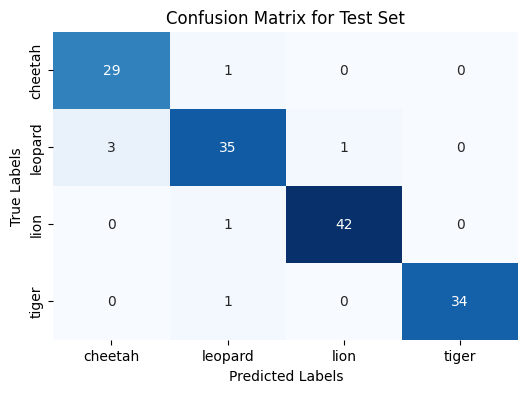

Misclassified Indices: [ 13  24  41  99 103 133 135]


In [20]:
# Create a VotingClassifier using the best Logistic Regression model (best_model_lr),
# the best Support Vector Machine model (best_model_svg), and the XGBoost model (xgb_model)
voting_clf = VotingClassifier(
    estimators=[('logistic', best_model_lr), ('svm', best_model_svg), ('xgboost', xgb_model)],
    voting='hard'  # Voting method set to 'hard', where the final prediction is the majority vote
)

# Train the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Use the VotingClassifier to predict labels for the validation set and testing set
y_val_pred = voting_clf.predict(X_val)
y_test_pred = voting_clf.predict(X_test)

# Calculate the accuracy of the VotingClassifier on the validation and testing sets
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the validation accuracy and test accuracy
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report for the validation set, which includes precision, recall, F1-score, and support
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Print the classification report for the test set, which includes precision, recall, F1-score, and support
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate the confusion matrix for the test set to evaluate the VotingClassifier's performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Find the indices of misclassified instances in the test set
misclassified_indices_hard = np.where(y_test_pred != y_test)[0]

# Print the indices of misclassified instances
print("Misclassified Indices:", misclassified_indices_hard)


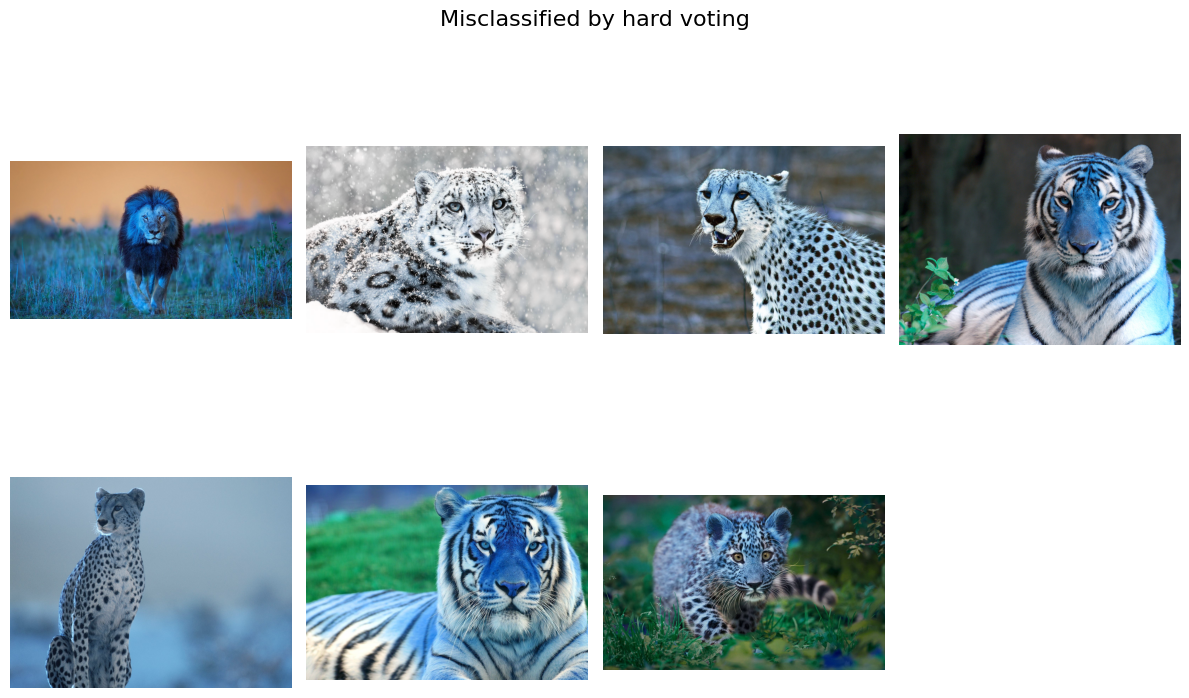

In [21]:
# Create a figure with a size of 12x8 inches to display the misclassified images
plt.figure(figsize=(12, 8))

# Iterate through the misclassified indices of the hard voting model's predictions
for i in range(len(misclassified_indices_hard)):
    # Get the image path from the DataFrame using the misclassified index
    image_path = df.iloc[misclassified_indices_hard[i], 0]

    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Create a subplot grid with 2 rows and 3 columns and set the current subplot position
    plt.subplot(2, 4, i + 1)

    # Display the image on the current subplot
    plt.imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    plt.axis('off')

# Add a super title to the entire figure
plt.suptitle('Misclassified by hard voting', fontsize=16)

# Adjust the spacing between the subplots to avoid overlap
plt.tight_layout()

# Show the figure with the misclassified images
plt.show()

## Creating a soft voting classifier  
In soft voting, the final prediction is determined by averaging the predicted probabilities (confidence scores) of each model.  
The class with the highest average probability becomes the final prediction.  
Soft voting is often used for models that can provide probabilities as output, such as logistic regression or support vector machines.

Validation Accuracy: 0.9166666666666666
Test Accuracy: 0.9523809523809523

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.82      0.88      0.85        16
           2       0.95      1.00      0.98        20
           3       0.96      0.92      0.94        24

    accuracy                           0.92        72
   macro avg       0.91      0.91      0.91        72
weighted avg       0.92      0.92      0.92        72


Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        30
           1       0.95      0.90      0.92        39
           2       0.98      0.95      0.96        43
           3       1.00      1.00      1.00        35

    accuracy                           0.95       147
   macro avg       0.95      0.95      0.95       147
weighted avg       0.95      0.95      0.95    

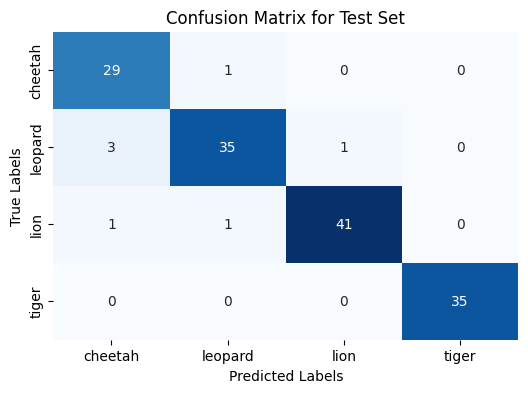

Misclassified Indices: [ 13  24  41  44 103 133 135]


In [22]:
# Create a Support Vector Machine model (SVM) with hyperparameters C=100 and kernel='rbf'
# Set probability=True to enable soft voting
best_model_svg_soft = SVC(C=100, kernel='rbf', probability=True)

# Create a VotingClassifier using the best Logistic Regression model (best_model_lr),
# the new Support Vector Machine model (best_model_svg_soft) with probability=True for soft voting,
# and the XGBoost model (xgb_model)
voting_clf_soft = VotingClassifier(
    estimators=[('logistic', best_model_lr), ('svm', best_model_svg_soft), ('xgboost', xgb_model)],
    voting='soft'  # Voting method set to 'soft', where the final prediction is based on probabilities
)

# Train the VotingClassifier on the training data
voting_clf_soft.fit(X_train, y_train)

# Use the VotingClassifier to predict labels for the validation set and testing set
y_val_pred = voting_clf_soft.predict(X_val)
y_test_pred = voting_clf_soft.predict(X_test)

# Calculate the accuracy of the VotingClassifier on the validation and testing sets
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the validation accuracy and test accuracy
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report for the validation set, which includes precision, recall, F1-score, and support
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Print the classification report for the test set, which includes precision, recall, F1-score, and support
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Calculate the confusion matrix for the test set to evaluate the VotingClassifier's performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(distinct_labels))
ax.set_yticklabels(sorted(distinct_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Find the indices of misclassified instances in the test set
misclassified_indices_soft = np.where(y_test_pred != y_test)[0]

# Print the indices of misclassified instances
print("Misclassified Indices:", misclassified_indices_soft)


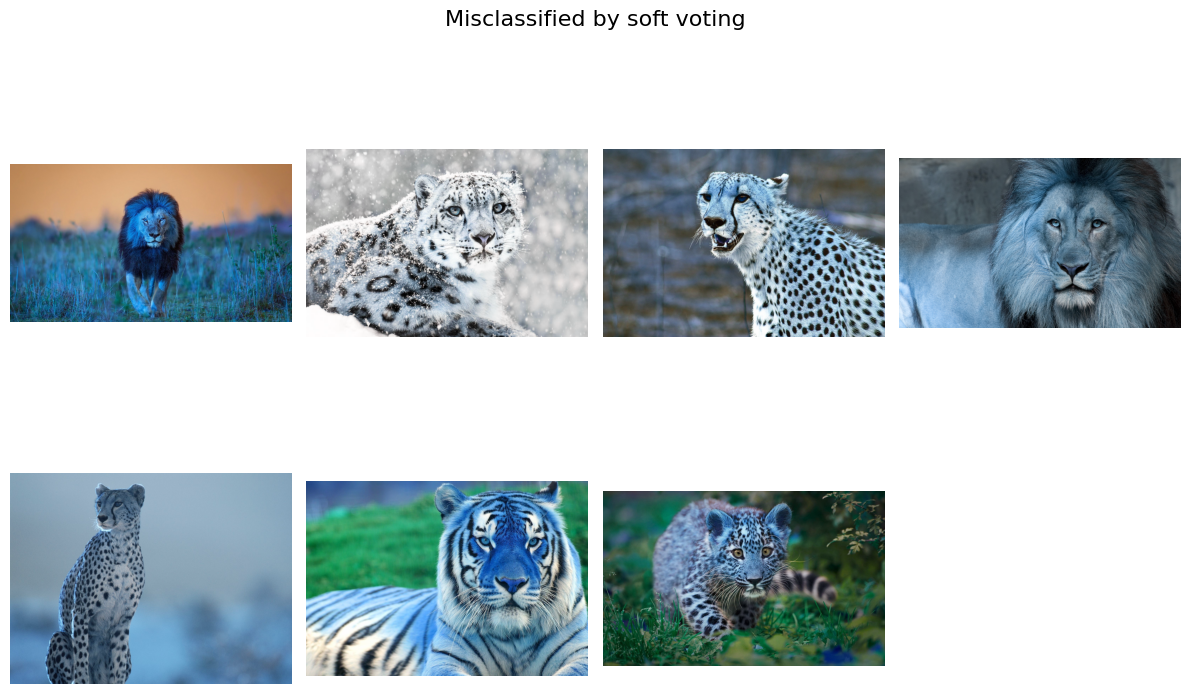

In [23]:
# Create a figure with a size of 12x8 inches to display the misclassified images
plt.figure(figsize=(12, 8))

# Iterate through the misclassified indices of the hard voting model's predictions
for i in range(len(misclassified_indices_soft)):
    # Get the image path from the DataFrame using the misclassified index
    image_path = df.iloc[misclassified_indices_soft[i], 0]

    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Create a subplot grid with 2 rows and 3 columns and set the current subplot position
    plt.subplot(2, 4, i + 1)

    # Display the image on the current subplot
    plt.imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    plt.axis('off')

# Add a super title to the entire figure
plt.suptitle('Misclassified by soft voting', fontsize=16)

# Adjust the spacing between the subplots to avoid overlap
plt.tight_layout()

# Show the figure with the misclassified images
plt.show()

# Choosing a model & implementing a prediction function
We see that the model that has the best test accuracy is SVM. So we chose it to make predictions

In [47]:
def predict(path):
    if path == '':
        raise ValueError("send the path of the photo to predict")
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature = np.array(vgg16_model.predict(img))
    num_samples, feature_dim = feature.shape[0], np.prod(feature.shape[1:])
    feature = feature.reshape(num_samples, feature_dim)

    prediction = best_model_svg.predict(feature)
    prediction = prediction[0]

    if prediction == 0:
        return "cheetah"
    elif prediction == 1:
        return "leopard"
    elif prediction == 2:
        return "lion"
    else:
        return "tiger"

    
    

In [55]:
print(predict("./animals/cheetah.jpeg"))
print(predict("./animals/leopard.jpeg"))
print(predict("./animals/lion.jpeg"))
print(predict("./animals/tiger.jpeg"))

1/1 [==============================] - 0s 133ms/step
cheetah
1/1 [==============================] - 0s 122ms/step
leopard
1/1 [==============================] - 0s 114ms/step
lion
1/1 [==============================] - 0s 128ms/step
tiger
